<a href="https://colab.research.google.com/github/will-stevenson813/Peronal-Work/blob/main/Machine_Learning_Final(William_Stevenson).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Machine Learning Midterm

## Importing Libraries

In [1]:
#Import all the necessary packages
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

#importing clustering algorithms
from sklearn.cluster import KMeans

#Importing PCA and TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

#Silhouette score
from sklearn.metrics import silhouette_score

# Regression & Decsision Tree Packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Reading in Data

In [2]:
# we import necessary procedures from colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Machine_Learning/MIDTERMANACONDA.csv')
data.head()

,Unnamed: 0,LOWPMPY,HIGHPMPY,BRalpha,pl,date,amount,icd10,cpt,PMPY,PCPY,Duration,BRregion,mMaxPL.y,HighRisk
0,1,227.48,3647.19,LUMB,6,2019-03-01,7,M4606,J1030,2755.60,138.28,4,SPINE,9,1
1,2,254.49,3124.69,LUMB,2,2020-06-01,0,M545,99213,2327.10,130.71,4,SPINE,5,1
2,3,403.85,5816.63,CERV,5,2020-08-01,27,M542,97140,3820.79,208.67,78,SPINE,5,1
3,4,125.82,1875.76,LUMB,0,2018-06-01,0,S39012D,81003,1084.89,68.35,60,SPINE,3,0
4,5,756.83,3822.98,CERV,4,2020-06-01,50,M9901,98941,2845.33,280.15,21,SPINE,8,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20000 non-null  int64  
 1   LOWPMPY     20000 non-null  float64
 2   HIGHPMPY    20000 non-null  float64
 3   BRalpha     20000 non-null  object 
 4   pl          20000 non-null  int64  
 5   date        20000 non-null  object 
 6   amount      20000 non-null  int64  
 7   icd10       20000 non-null  object 
 8   cpt         20000 non-null  object 
 9   PMPY        20000 non-null  float64
 10  PCPY        20000 non-null  float64
 11  Duration    20000 non-null  int64  
 12  BRregion    20000 non-null  object 
 13  mMaxPL.y    20000 non-null  int64  
 14  HighRisk    20000 non-null  int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 2.3+ MB


# Data Dictionary


LOWPMPY: Per-Member Per-year amount observed for Low-Risk patients for each subset.

HIGHPMPY: Per-Member Per-year amount observed for High-Risk patients for each subset.

BRalpha: Body region in question on claim

pl: Denotes the severity of the procedure in that claim

date: Month in which the procedure was done

amount: The amount billed to the insurance company for each procedure

icd10: Code corresponding to the diagnosis of the patient at the time of that procedure

cpt: Code corresponding to the acutal procudure that was given to the patient in that claim

PMPY: Average Per-Member Per-year amount observed for each subset.

PCPY: Per-Claim Per-Year metric calculated by susbset

Duration: How long each patient was rendered care for a specific ailment

BRregion: Custom tuned body region groups that each claim fell into

mMaxPL.y: The max PL that each patient achieved that year. (Is reset every year)

High-Risk: 1 if patient had a claim of severity level 5 or over. 0 otherwise.

# Fantastic
It looks like all of our variables do have non-null values. Complete dataset.

# No need to check for duplicates, we know they are all individual

We can go ahead and drop: 'Unnamed: 0', 'BRalpha, 'BRregion', 'icd10','cpt','date' either because they are useless or catagorical variables that do not really help our analysis

In [5]:
data = data.drop(['Unnamed: 0', 'BRalpha', 'BRregion', 'icd10', 'cpt','date'], axis = 1)

Next, let us get some summary statistics of our dataset

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
LOWPMPY,20000.0,347.837131,205.151163,83.43,227.48,279.63,447.11,780.19
HIGHPMPY,20000.0,3965.447851,1782.615461,961.69,2902.76,3615.32,5355.51,8192.32
pl,20000.0,4.118350,2.934344,0.00,2.00,5.00,5.00,9.00
amount,20000.0,179.866700,1553.848423,-14438.00,0.00,32.00,98.00,126507.00
PMPY,20000.0,2678.960899,1206.171927,569.81,1394.01,2755.60,3438.65,5179.47
PCPY,20000.0,170.364990,85.504875,68.35,100.50,138.28,208.67,489.19
Duration,20000.0,35.662900,39.616416,0.00,4.00,21.00,56.00,174.00
mMaxPL.y,20000.0,6.274650,2.534648,0.00,5.00,6.00,9.00,9.00
HighRisk,20000.0,0.816250,0.387290,0.00,1.00,1.00,1.00,1.00


It seems like their are some negative values in our 'amount' variable. These are for when an insurnace company miss-charged a patient and is setteling that mishap. We will ignore them for our analysis.

Some high LOWPMPY subsets make the mean larger than the median.

Amount is also skewed with mean much higher than median.

Some really long durations make the mean quite a bit larger than the median.

In [7]:
Data2 = data[data.amount >= 0] 

In [8]:
Data2.describe().T
Data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19903 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LOWPMPY   19903 non-null  float64
 1   HIGHPMPY  19903 non-null  float64
 2   pl        19903 non-null  int64  
 3   amount    19903 non-null  int64  
 4   PMPY      19903 non-null  float64
 5   PCPY      19903 non-null  float64
 6   Duration  19903 non-null  int64  
 7   mMaxPL.y  19903 non-null  int64  
 8   HighRisk  19903 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.5 MB


No missing values, that is nice.

HIGHPMPY
Skew : 0.73


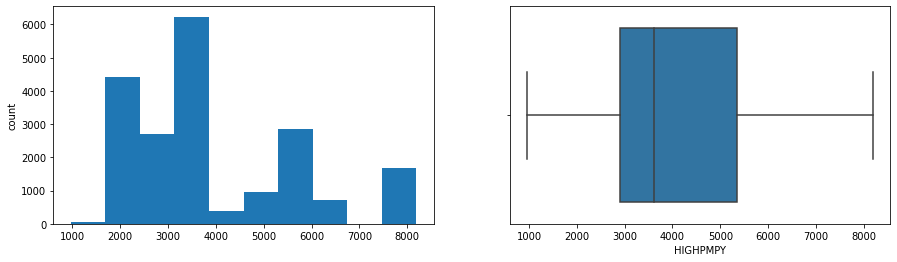

pl
Skew : 0.1


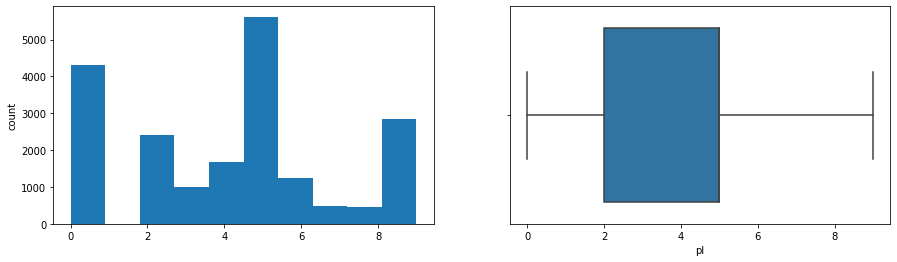

amount
Skew : 50.09


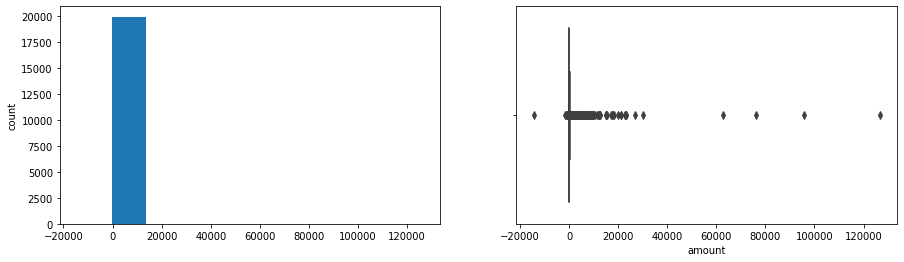

PMPY
Skew : 0.26


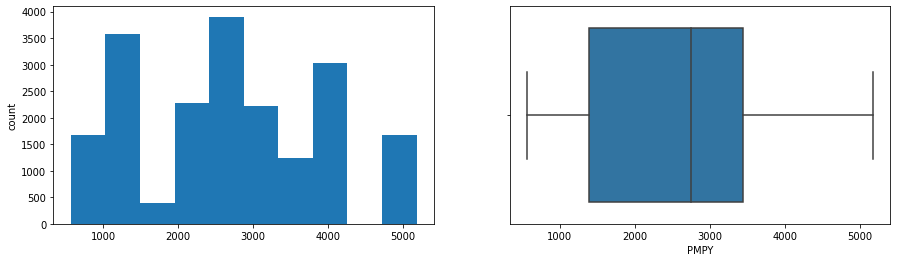

PCPY
Skew : 0.87


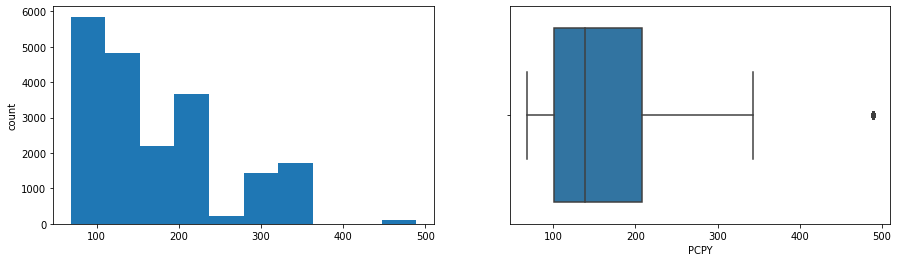

Duration
Skew : 1.19


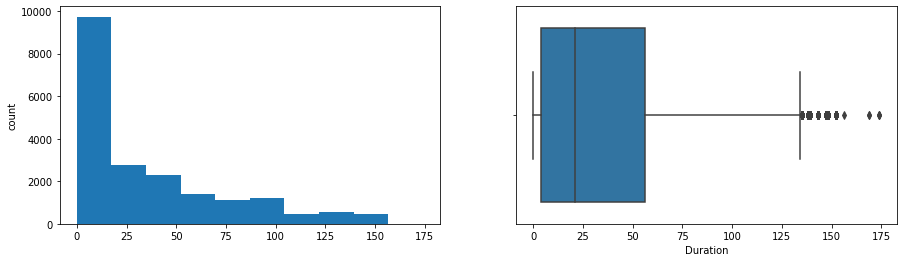

mMaxPL.y
Skew : -0.6


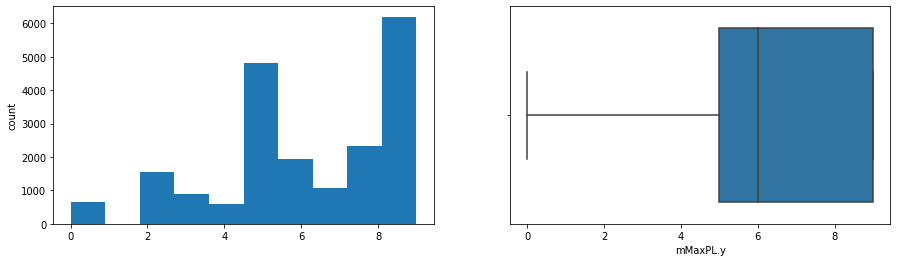

HighRisk
Skew : -1.63


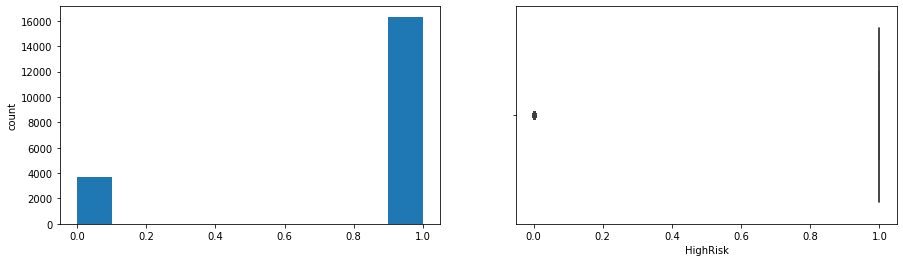

In [9]:
for col in data.columns[1:]:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

Some very large HIGHPMPY's pull the mean up.

Lots of people have very low severity procedures which explains all the low values. A spike at PL = 5 becuase that is injections, which happens quite a bit.

Massive outliers in amount as very few people have massive charges. 

Some subsets have less claims than others so that skews this metric.

Duration also heavily skewed. Most people do have an ailment for too long, while a few others have really extended problems.

mMaxPL is possibly right skewed becuase it is the MAX of peoples procedure levels.

High risk is either zero or one, so that is why it looks weird.

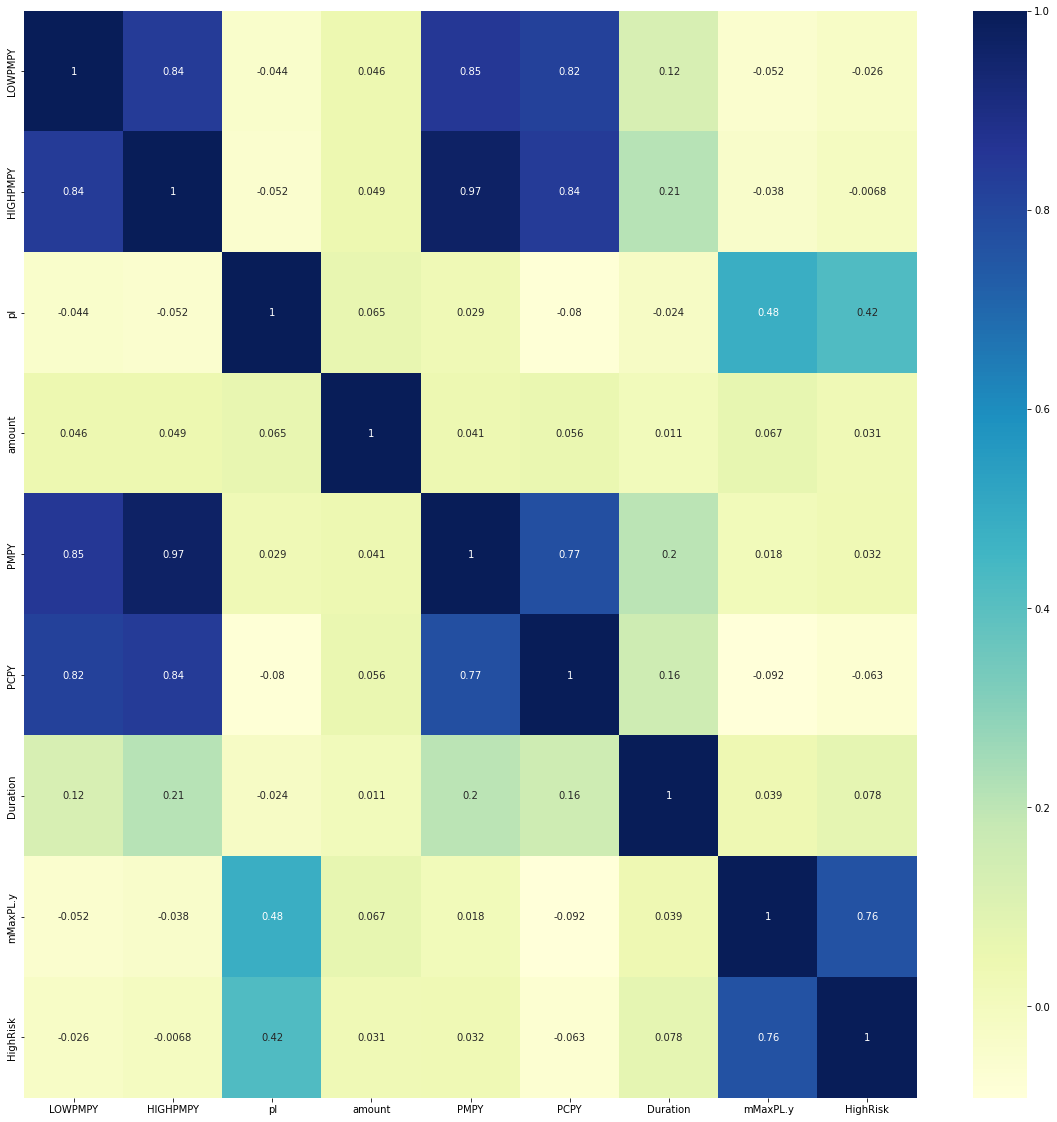

In [10]:
plt.figure(figsize  = (20,20))
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")
plt.show()

 HIGH & LOW PMPY are highly correlated. I think this is probably becuase certian subsets have fewer observations than others, which leads to higher variability in both of these figures. 
 
 HighRisk and mMaxPL are also correlated because your mMAxPL is what determines if you are High or Low Risk.
 
 HIGHPMPY and PMPY are correlated probably becuase it is basically an average of LOWPMPY and HIGHPMPY. LOWPMPY tends to have lower variability, so most of the average (PMPY) variability comes from HIGHPMPY. This is why PMPY is also correlated with LOWPMPY, but to a lesser degree.

Copy the dataset before we scale it to preserve original data

In [11]:
#Scaling the data and storing the output as a new dataframe
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(Data2), columns=data.columns)

data_scaled.head()

,LOWPMPY,HIGHPMPY,pl,amount,PMPY,PCPY,Duration,mMaxPL.y,HighRisk
0,-0.588792,-0.180902,0.640848,-0.112825,0.060550,-0.378168,-0.799574,1.075806,0.474767
1,-0.457157,-0.473922,-0.722317,-0.117330,-0.294813,-0.466697,-0.799574,-0.502534,0.474767
2,0.270759,1.035724,0.300057,-0.099953,0.943933,0.445024,1.066419,-0.502534,0.474767
3,-1.084239,-1.174324,-1.403900,-0.117330,-1.325001,-1.195980,0.612529,-1.291704,-2.106298
4,1.991031,-0.082319,-0.040735,-0.085151,0.134965,1.280963,-0.370900,0.681221,0.474767


In [12]:
#Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep=True)

# Principal Component Analysis

In [13]:
#Defining the number of principal components to generate 
n=data_scaled.shape[1] 

print(data_scaled.shape) # We could come up with 20 components (Too many lol)

#Finding principal components for the data

pca = PCA(n_components=n, random_state=1)

data_pca1 = pd.DataFrame(pca.fit_transform(data_scaled))

#The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_



(19903, 9)


Text(0, 0.5, 'Cumulative Explained Variance')

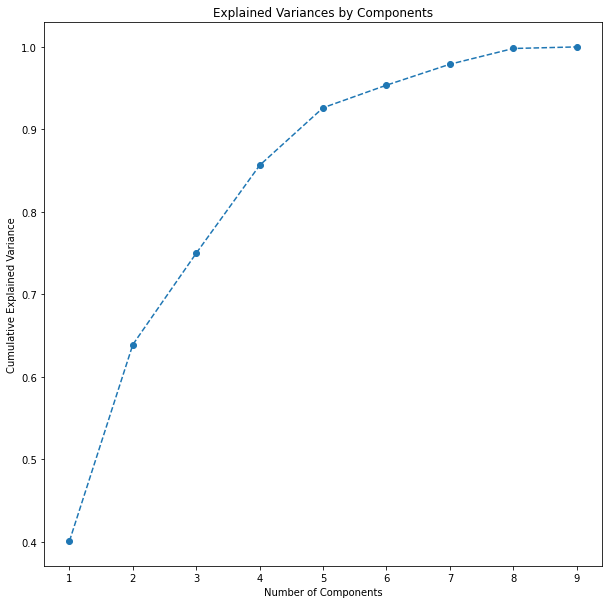

In [14]:
# visualize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,10), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [15]:
# find the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(exp_var): #enumerate is giving us a list (usually want ix)
  print(ix,i)
  sum = sum + i
  if(sum>0.70):
    print("Number of PCs that explain at least 70% variance: ", ix+1)
    break

0 0.40082228760086774
1 0.23829334707921151
2 0.11077965045438229
Number of PCs that explain at least 70% variance:  3


In [16]:
pc_comps = ['PC1','PC2','PC3']
data_pca = pd.DataFrame(np.round(pca.components_[:3,:],2),index=pc_comps,columns=data_scaled.columns)
data_pca.T # you basically just want one or two of the factors to explain most variance of sinlge variables

,PC1,PC2,PC3
LOWPMPY,0.49,0.01,0.03
HIGHPMPY,0.51,0.03,-0.01
pl,-0.04,0.49,0.08
amount,0.03,0.09,0.91
PMPY,0.50,0.08,-0.02
PCPY,0.48,-0.02,0.03
Duration,0.13,0.07,-0.37
mMaxPL.y,-0.04,0.62,-0.04
HighRisk,-0.03,0.60,-0.11


In [17]:
def color_high(val):
    if val <-0.25: # you can decide any value as per your understanding
        return 'background: pink'
    elif val >0.25:
        return 'background: skyblue'   
    
data_pca.T.style.applymap(color_high)

,PC1,PC2,PC3
LOWPMPY,0.490000,0.010000,0.030000
HIGHPMPY,0.510000,0.030000,-0.010000
pl,-0.040000,0.490000,0.080000
amount,0.030000,0.090000,0.910000
PMPY,0.500000,0.080000,-0.020000
PCPY,0.480000,-0.020000,0.030000
Duration,0.130000,0.070000,-0.370000
mMaxPL.y,-0.040000,0.620000,-0.040000
HighRisk,-0.030000,0.600000,-0.110000


PC1 seems to related to subsets that have higher overall costs across the board. LOWPMPY & HIGHPMPY are high, average PMPY is high, and PCPY is high. 

PC2 seems to relate to subsets that have a high severity of cases. High PL's which in turn would mean higher mMaxPL, and in turn more HighRisk individuals.

PC3 seems to relate to inidviduals who have expensive procedures, but do not deal with that ailment for long. This is probably things like emergency room visits for accidents.

Text(0, 0.5, 'PC2')

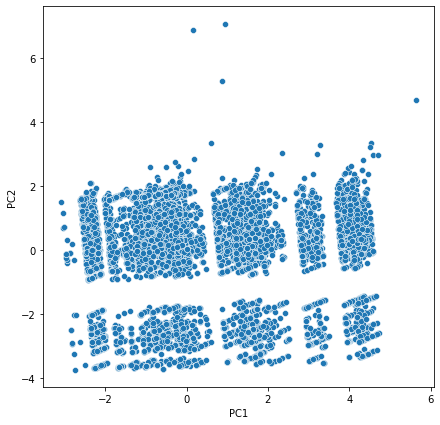

In [18]:
plt.figure(figsize = (7,7))
sns.scatterplot(x=data_pca1[0],y=data_pca1[1])
plt.xlabel("PC1")
plt.ylabel("PC2") # Ideally we want clusters of data points

We can see from this clustering graph that our subsets do appear denoted by the vertical breaks. The horizontal break is probably from varying level of procedures as that is the main factor in PC2.

# TSNE

In [19]:
#Fitting TSNE with number of components equal to 3 
tsne = TSNE(n_components = 3, random_state=1)
data_tsne = tsne.fit_transform(data_scaled)

KeyboardInterrupt: ignored

In [ ]:
#Converting the embeddings to a dataframe
data_tsne=pd.DataFrame(data_tsne, columns=['X1', 'X2', 'X3'])

In [ ]:
#Scatter plot for two components
plt.figure(figsize = (7,7))
sns.scatterplot(x = 'X1', y='X2', hue='X3', data = data_tsne)

Unfortunatly, no real obvious clusers come from this graph. This is proably due to the fact that insurance claims as well as medical events are extremly difficult to cluster unless you include a ton of demographic information on each of the individuals. As I am an unpaid intern, I do not get access to this type of information.

# K-Means clustering

In [ ]:
#Empty dictionary to store the SSE for each value of k
sse = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    sse[k] = kmeans.inertia_

#Elbow plot
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Nothing strange here. We do not get a sharp drop off in SSE, so we will have to use a Silhouette Score to get a better idea of the ideal number of clusters.

In [ ]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show() # Want high Silhouette Score

We see the highest score was achieved by 4 clusters, so that is how many we will continue with.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(data_scaled)

#Adding predicted labels to the original data and scaled data 
data_scaled_copy['KMeans_Labels'] = kmeans.predict(data_scaled)
Data2['KMeans_Labels'] = kmeans.predict(data_scaled)

In [ ]:
Data2['KMeans_Labels'].value_counts() # Counts of countires in each cluster

In [ ]:
#Calculating mean and median of the original data for each label
mean = Data2.groupby('KMeans_Labels').mean()
median = Data2.groupby('KMeans_Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean','group_3 Mean',
                   'group_0 Median', 'group_1 Median', 'group_2 Median','group_3 Median']
df_kmeans.T

All median and means should be a little more normally distributed as they are in clusters of like-observations.

In [ ]:
cols_visualise = ['LOWPMPY','HIGHPMPY','pl','amount','PMPY','PCPY','Duration','mMaxPL.y','HighRisk']

for col in cols_visualise:
    sns.boxplot(x = 'KMeans_Labels', y = col, data = Data2)
    plt.show()

Quite a high LOWPMPY & HIGHPMPY for cluster two (kMeans_Lable [2].

PL average and mean quite low for group 3.

More outliers in 'amount' for groups 1 & 2 compared to group 3.

Higher average PMPY, PCPY, for group 2.

Seems to be much lower mMaxPL for group 3 than the others.

I am guessing that Cluster 1 contains individuals/subsets with relatively average paths of care/claims. 

Cluster 2 probably is individuals/subsets that have a lower count of claims/members which tend to be more susceptible to outliers of expensive claims.  

Cluster 3 probably is individuals/subsets that hare relatively 'normal' except for much lower PL's which in turn would mean lower mMaxPL's and less High-Risk individuals. 

Do not need to pay much attention to the group_3 as is only has 4 observations in it.

# Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Way too many observations for Hierarchical Clustering to really work. Take a sample of our dataset to make things easier.

In [ ]:
data_sub = data_scaled.sample(n = 150)
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete']

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(20, 15))

# Enumerate through the list of all methods above, get linkage and plot dendrogram
for i, method in enumerate(methods):
    Z = linkage(data_sub, metric='euclidean', method=method)
    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    axs[i].set_ylabel('Distance')

In [ ]:
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(data_sub, method='complete'))
plt.axhline(y=4.75, color='r', linestyle='--')

In [ ]:
#Clustering with number of clusters equal to 4
hierarchical = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='complete')
hierarchical.fit(data_sub)

In [ ]:
data_sub['HCLabels'] = hierarchical.labels_
data_sub['HCLabels'] = hierarchical.labels_

In [ ]:
data_sub.HCLabels.value_counts()

In [ ]:
varss = ['LOWPMPY','HIGHPMPY','pl','amount','PMPY','PCPY','Duration','mMaxPL.y','HighRisk']

for col in varss:
    sns.boxplot(x = 'HCLabels', y = col, data = data_sub)
    plt.show()

It seems that our Hierarchical Clustering came to the same conclusing as our K-Means clustering, returning 4 clusters with the final one (HCLables[2]) being a catch-all of observations that could not be clustered into the other groups.

# Machine Learning Final Section

## Linear Regression

In [ ]:
# Reading in Data
data = pd.read_csv('/content/drive/MyDrive/Machine_Learning/MIDTERMANACONDA.csv')
data.head()

In [ ]:
# Dropping variables not necessary for this part of the analysis
DataReg = data.drop(['LOWPMPY','HIGHPMPY','PMPY','PCPY','Unnamed: 0', 'BRalpha', 'BRregion', 'icd10', 'cpt','date'], axis = 1)
DataReg.head()

DataReg = DataReg[DataReg.amount >= 0] 

DataReg.info()

In [ ]:
#Defining response and predictor variables
X = DataReg[['Duration','pl','amount']]
Y = DataReg['HighRisk']

# The variable of interest is already a dummy.

#Scaling the data
sc=StandardScaler()
X_scaled=sc.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled, columns=X.columns)

# Performing Test-Train Split
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,Y,test_size=0.3,random_state=0)

#creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['LowRisk', 'HighRisk'], yticklabels=['LowRisk', 'HighRisk'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,Y_train)

#use model to make predictions on test data
Y_pred = log_regression.predict(X_train)
metrics_score(Y_train, Y_pred)

#checking the performance on the test dataset
y_pred_test = log_regression.predict(X_test)
metrics_score(Y_test, y_pred_test)

### Observations
- Getting to about 80% accuracy in both testing and training.
- We are also able to have a recall rate of about 90% in testing and training for HighRisk Individuals.
- The model is probably not so accurate as it classified 759 cases as High Risk when they were low risk, but still missed 406 High Risk cases. It seems like the model is simply trying to have a higher recall than accuracy.

## Percision-Recall tradeoff curve

In [ ]:
y_scores_lg=log_regression.predict_proba(X_train) #predict_proba gives the probability of each observation belonging to each class


precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(Y_train, y_scores_lg[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

### Observations
- It seems like this model is actually quite precise even when we try to maxamize recall rate.
- Perhaps I am mistaken, this model is actually quite good.

## Decision Trees

In [ ]:
DataTree = pd.read_csv('/content/drive/MyDrive/Machine_Learning/MIDTERMANACONDA.csv')
DataTree = DataTree.drop(['Unnamed: 0', 'BRalpha', 'BRregion','date','icd10','pl','mMaxPL.y','cpt'], axis = 1)
DataTree = DataTree[DataTree.amount >= 0] 
DataTree.head()

- Unfortunatly we have to drop more variables as they are used to asses High vs. Low Risk, all other variabels are catagorical

In [ ]:
labels = np.array(DataTree.pop('HighRisk'))

In [ ]:


# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(DataTree, labels, 
                                                          stratify = labels, 
                                                          test_size = 0.3, 
                                                          random_state = 0)
## Stratify means to maintain the percentage distribution of 'labels' in both test and train split

# Features for feature importances
features = list(train.columns)

# Train tree
tree = DecisionTreeClassifier(random_state=0, max_depth = 13)
model_tree=tree.fit(train, train_labels)

In [ ]:
# Train tree
tree = DecisionTreeClassifier(random_state=0, max_depth = 13)

tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

In [ ]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

In [ ]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [ ]:
evaluate_model(predictions, probs, train_predictions, train_probs) 
# Recall is ability to identify all points in a relevant class
# Preciision is the ability for a model to return only the data points in one class.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [ ]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = [ 'LowRisk', 'HighRisk'],
                      title = 'Risk Level Confusion Matrix')

In [ ]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

- It seems like the amount charged to the insurnace company is the most important thing in determining if it was a High Risk case or Low Risk.
- Duration was also a very key variable. The long someone is in the hospital, the more likely they are having a serious issue that would be classified as HighRisk.

In [ ]:
import subprocess
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from PIL import Image

fig = plt.figure(figsize=(30,25))
plot_tree(tree, max_depth=3, feature_names = features, fontsize = 20)

- With a maximum depth of 13 we end up with 1,949 nodes. Way too many to reasonably conceptualize. Next we will move onto Random Forest to see if we can get better results from a median tree.

## Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# First let's try 100 tree's and see how well that performs. This first time around we will leave the maximum depth at 13 
# to see if any imporvements are made.

treemodel100 = RandomForestClassifier(n_estimators=100, 
                               random_state=0, 
                               max_features = 'sqrt',
                              class_weight='balanced', 
                              max_depth = 13)  # Balanced splits because want to make sure we include High and Low Risk
                                               # persons in both training and testing splits

# Fit on training data
treemodel100.fit(train, train_labels)

In [ ]:
# Checking average depth and node count to see if we made any imporvements
n_nodes = []
max_depths = []

for ind_tree in treemodel100.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# slight improvements in node count.
# Let us check some evaluations statistics to how well it performed.

In [ ]:
# Gathering stats
train_model100_predictions = treemodel100.predict(train)
train_model100_probs = treemodel100.predict_proba(train)[:, 1]

model100_predictions = treemodel100.predict(test)
model100_probs = treemodel100.predict_proba(test)[:, 1]

In [ ]:
# Evaluate model and draw ROC curve
evaluate_model(model100_predictions, model100_probs, train_model100_predictions, train_model100_probs)

- Random forest with 100 trees traded some recall for precision. The single tree achieved 93% recall in testing with a percision of 84%.

- Random Forest with 100 trees ended up with only 81% recall in testing, but achieved a percision of 88% in testing.

Let us look at a confusion matrix of the Random forest with 100 trees too see how the classification ended up.

In [ ]:
cm = confusion_matrix(test_labels, model100_predictions)
plot_confusion_matrix(cm, classes = [ 'Low Risk', 'High Risk'],
                      title = 'Risk Level Confusion Matrix')

- The most interesting thing is that the model we reduced the number of times a Low Risk Claim was predicted to be a High Risk. Unfortunatly, the model also missed more High Risk claims than the single tree.
- If the goal was to reduced the chance that we miss-classify a Low Risk case as High Risk, Random Forest performs better than Single Decision Tree.
- If the goal was to miss as few High Risk Claims as possible, the Random Forest performs worse than Single Decision Tree.
    - This is due to Recall and Percision being tradeoff's 
    
 Let us try 300 trees with say a depth of 9 to see if we can conceptualize the Decision tree a little better but still retain relativly good efficiency/percision

## Random Forest with 300 trees

In [ ]:
treemodel300 = RandomForestClassifier(n_estimators=100, 
                               random_state=0, 
                               max_features = 'sqrt',
                              class_weight='balanced', 
                              max_depth = 9)  # Balanced splits because want to make sure we include High and Low Risk
                                               # persons in both training and testing splits

# Fit on training data
treemodel300.fit(train, train_labels)

In [ ]:
# Checking average depth and node count to see if we made any imporvements
n_nodes = []
max_depths = []

for ind_tree in treemodel300.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Much fewer nodes, hopefully accuracy metrics are still okay.

In [ ]:
train_model300_predictions = treemodel300.predict(train)
train_model300_probs = treemodel300.predict_proba(train)[:, 1]

model300_predictions = treemodel300.predict(test)
model300_probs = treemodel300.predict_proba(test)[:, 1]

# Evaluate model and draw ROC curve
evaluate_model(model300_predictions, model300_probs, train_model300_predictions, train_model300_probs)

In [ ]:
cm = confusion_matrix(test_labels, model300_predictions)
plot_confusion_matrix(cm, classes = ['Low Risk', 'High Risk'],
                      title = 'Risk Level Confusion Matrix (300Trees)')

### Observations
- Slight improvement over the other random forest. Slightly better percision in the testing group (89 vs 88). However, now our recall rate is falling more (78 vs 81). Any more strides taken to try and increase percision will start to affect recall rate drastically.
- Probably have taken base Random Forest as far as it can with this dataset.
- However, what about utilizing grid search to optimize our hyperparameters?

## Random Forest Utilizing Random Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 0)

# Create the random search model
RandomSearch = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=0)

# Fit 
RandomSearch.fit(train, train_labels)

In [ ]:
# Finding the best parameters
RandomSearch.best_params_

In [ ]:
best_model = RandomSearch.best_estimator_

In [ ]:
# Splitting data and extracting predictions
train_Grid_predictions = best_model.predict(train)
train_Grid_probs = best_model.predict_proba(train)[:, 1]

Grid_predictions = best_model.predict(test)
Grid_probs = best_model.predict_proba(test)[:, 1]

In [ ]:
evaluate_model(Grid_predictions, Grid_probs, train_Grid_predictions, train_Grid_probs)

In [ ]:
# Drawing the ensemble Decision Tree
from sklearn import tree
estimator = best_model.estimators_[1]

fig = plt.figure(figsize=(35,30))
tree.plot_tree(estimator, max_depth=10, feature_names = features, fontsize = 13)
fig.savefig("tree_estimator.png")

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [ ]:
cm = confusion_matrix(test_labels, Grid_predictions)
plot_confusion_matrix(cm, classes = ['Low Risk', 'High Risk'],
                      title = 'Risk Level Confusion Matrix (Random Grid)')

## Observations
- It seems like utilizing the Random Grid Search favored more percision than recall amoungst all of our models. 
- Grid Search was able to cut down on the number of nodes as well as depth of the Decision Tree, so I would say this was a success.
- Random Forest with a Random Grid Search was able to produce a more efficent Decision Tree compared to the single Decision Tree, the Random Forest with 100 and 300 trees.
- Compared to our Logistic Regression, our Decision Tree models seemed to favor higher percision. This would make sense as Logistic Regressions aims to classify all observations as best as they can. Decision tree models aim to try and bake in better accuracy as well as offering the flexibilty to decide where in that tradeoff between recall and percision you would like to be.

## Deep Learning Using Artifical Nerual Networks

In [20]:
# Reading in the data again to restart
DataLearn = pd.read_csv('/content/drive/MyDrive/Machine_Learning/MIDTERMANACONDA.csv')
DataLearn.head()
DataLearn = DataLearn.drop(['Unnamed: 0', 'BRalpha', 'BRregion','date','icd10','mMaxPL.y','cpt'], axis = 1)
# Dropping unnecessary variables

In [21]:
# Make dummy variables for PL's
DummyData = pd.concat([DataLearn, pd.get_dummies(DataLearn['pl'], prefix='pl')], axis=1)
DummyData = DummyData.drop(['pl'], axis = 1)

DummyData.describe()


,LOWPMPY,HIGHPMPY,amount,PMPY,PCPY,Duration,HighRisk,pl_0,pl_2,pl_3,pl_4,pl_5,pl_6,pl_7,pl_8,pl_9
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,347.837131,3965.447851,179.866700,2678.960899,170.364990,35.662900,0.81625,0.216000,0.119950,0.050200,0.083750,0.280950,0.061500,0.023750,0.022250,0.14165
std,205.151163,1782.615461,1553.848423,1206.171927,85.504875,39.616416,0.38729,0.411525,0.324911,0.218363,0.277019,0.449474,0.240251,0.152273,0.147499,0.34870
min,83.430000,961.690000,-14438.000000,569.810000,68.350000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,227.480000,2902.760000,0.000000,1394.010000,100.500000,4.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,279.630000,3615.320000,32.000000,2755.600000,138.280000,21.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,447.110000,5355.510000,98.000000,3438.650000,208.670000,56.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000
max,780.190000,8192.320000,126507.000000,5179.470000,489.190000,174.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [22]:
# Copying our data for further analysis and scalling
# Dividing all values by the max is a safe way to scale
ScaledData = DummyData[:]

ScaledData['LOWPMPY'] = ScaledData['LOWPMPY']/780.19
ScaledData['HIGHPMPY'] = ScaledData['HIGHPMPY']/8192.32
ScaledData['amount'] = ScaledData['amount']/126507
ScaledData['PMPY'] = ScaledData['PMPY']/5179.47
ScaledData['PCPY'] = ScaledData['PCPY']/489.190
ScaledData['Duration'] = ScaledData['Duration']/174


In [23]:
# Sometimes train_test_split does not work from SkLearn. This is the more 'reliable' way to do it.
sample = np.random.choice(ScaledData.index, size=int(len(ScaledData)*0.9), replace=False)
train_data, test_data = ScaledData.iloc[sample], ScaledData.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 18000
Number of testing samples is 2000
        LOWPMPY  HIGHPMPY    amount      PMPY      PCPY  Duration  HighRisk  \
4600   0.511363  0.462514  0.000000  0.470481  0.406202  0.000000         1   
15805  0.511363  0.462514  0.000451  0.470481  0.406202  0.143678         0   
13127  1.000000  0.923271  0.001494  0.979428  0.655778  0.022989         0   
3457   0.158410  0.209566  0.000142  0.191803  0.169075  0.522989         1   
8145   0.158410  0.209566  0.012774  0.191803  0.169075  0.247126         1   
8349   0.326190  0.381417  0.002253  0.449293  0.267197  0.000000         1   
17542  0.291570  0.445196  0.000909  0.532024  0.282671  0.396552         1   
2639   0.316846  0.424786  0.000174  0.476713  0.476543  0.218391         1   
6907   0.291570  0.445196  0.000142  0.532024  0.282671  0.419540         1   
11563  0.375588  0.349524  0.000000  0.328711  0.257814  0.247126         1   

       pl_0  pl_2  pl_3  pl_4  pl_5  pl_6  pl_7  pl_8  pl_9 

Next, we must split our data into its features and target variable (HighRisk/LowRisk in this case)

In [24]:
import keras
import tensorflow
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
# For some reason, Keras and TensorFlow likes NumPy better than Pandas.
features = np.array(train_data.drop('HighRisk', axis=1))
targets = np.array(keras.utils.np_utils.to_categorical(train_data['HighRisk'], 2))
features_test = np.array(test_data.drop('HighRisk', axis=1))
targets_test = np.array(keras.utils.np_utils.to_categorical(test_data['HighRisk'], 2))

print(features[:10])
print(targets[:10])

[[5.11362617e-01 4.62513671e-01 0.00000000e+00 4.70480570e-01
  4.06202089e-01 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.11362617e-01 4.62513671e-01 4.50567953e-04 4.70480570e-01
  4.06202089e-01 1.43678161e-01 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.23270819e-01 1.49398847e-03 9.79428397e-01
  6.55777919e-01 2.29885057e-02 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.58410131e-01 2.09565788e-01 1.42284617e-04 1.91803408e-01
  1.69075410e-01 5.22988506e-01 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.58410131e-01 2.09565788e-01 1.27739967e-02 1.91803408e-01
  

In [39]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

# Building the first model
model1 = Sequential()
model1.add(Dense(128, activation='relu', input_shape=(15,)))
model1.add(Dropout(.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(.1))
model1.add(Dense(2, activation='softmax'))

# Second model with slightly different strucutre 
model2 = Sequential()
model2.add(Dense(64, activation = 'relu', input_shape=(15,)))
model2.add(Dropout(.2))
model2.add(Dense(12, activation = 'relu'))
model2.add(Dropout(.1))
model2.add(Dense(2, activation = 'softmax'))

# Third model with a sprase strucutre 
model3 = Sequential()
model3.add(Dense(12, activation = 'relu', input_shape=(15,)))
model3.add(Dropout(.2))
model3.add(Dense(4, activation = 'relu'))
model3.add(Dropout(.1))
model3.add(Dense(2, activation = 'softmax'))

# Compiling the model
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

#Compiling model 2
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])
model2.summary()

#Compiling model 3
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               2048      
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 2)                 130       
                                                                 
Total params: 10,434
Trainable params: 10,434
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
____________________________

In [40]:
# Training the model
model1.fit(features, targets, epochs=200, batch_size=100, verbose=0)
model2.fit(features, targets, epochs = 200, batch_size = 100, verbose = 0)
model3.fit(features, targets, epochs=200, batch_size = 100, verbose = 0)

In [41]:
# Evaluating the model on the training and testing set
score = model1.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model1.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

# Evaluating model2 on the training and testing set
score = model2.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model2.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

# Evaluating model3 on the training and testing set
score = model3.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model3.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

563/563 [==============================] - 1s 2ms/step - loss: 0.2788 - accuracy: 0.8523

 Training Accuracy: 0.8523333072662354
63/63 [==============================] - 0s 1ms/step - loss: 0.2899 - accuracy: 0.8480

 Testing Accuracy: 0.8479999899864197
563/563 [==============================] - 1s 2ms/step - loss: 0.2826 - accuracy: 0.8482

 Training Accuracy: 0.8482221961021423
63/63 [==============================] - 0s 1ms/step - loss: 0.2924 - accuracy: 0.8445

 Testing Accuracy: 0.8445000052452087
563/563 [==============================] - 1s 1ms/step - loss: 0.2887 - accuracy: 0.8473

 Training Accuracy: 0.8473333120346069
63/63 [==============================] - 0s 1ms/step - loss: 0.2950 - accuracy: 0.8425

 Testing Accuracy: 0.8424999713897705


## Observations
- Fantasitc! It seems that we have retianed about the same level of accuracy (~85% in Testing) for both models, even though model2 has about 1/10 the parameters as model1. 
- It seems like our sparse model3 is still quite effective. With only 254 parameters the model stil achieves about 84% accuracy in the testing set.

- All of this points to the conclusion that some very simple ANN models do an effective job of classifying High Risk cases from Low Risk ones.